In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification
import random

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [3]:
epochs = 20
seed_val = 2
results_window = {}
max_len = 25
stop_at = 5
cuda_card = 0

In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    test_texts, _, test_labels, sentences_test, test_target_words, test_positions = read_lexical_corpus('data/raw/lcp_single_trial.xlsx',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds_val = []
    history_preds_test = []
    history_samples_val = []
    history_samples_test = []
    history_input = []
    history_input_test = []
    history_target = []
    history_target_test = []
    history_index = []
    history_index_test = []
    history_labels_val = []
    history_labels_test = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')

        train_index = list(train_index)
        random.seed(seed_val)
        random.shuffle(train_index)
        train_index = np.array(train_index)
        
        train_texts, train_labels, train_positions, train_target_words = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
        val_texts, val_labels, val_positions, val_target_words = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]

        train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
        train_dataset = LexDataset(train_encodings, train_labels, train_positions)
        train_loader = DataLoader(train_dataset, batch_size=16)

        val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
        val_dataset = LexDataset(val_encodings, val_labels, val_positions)
        val_loader = DataLoader(val_dataset, batch_size=1)

        test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
        test_dataset = LexDataset(test_encodings, test_labels, test_positions)
        test_loader = DataLoader(test_dataset, batch_size=1)
        
        all_text = ' '.join(train_texts)
        occurence_text = [all_text.count(w) for w in val_target_words]
        
        occurence_target = [train_target_words.tolist().count(w) for w in val_target_words]
        
        device = torch.device("cuda:1")
        
        model = BertForSharedTaskBaseline.from_pretrained(
            "bert-base-uncased", 
            num_labels = 1, 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda(1)

        optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )
        device = torch.device("cuda:1")

        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        
        tracking_metrics_val = []
        tracking_logits_val = []

        tracking_metrics_test = []
        tracking_logits_test = []
    
        early_stopping = 0
        best_metric = 1000000
        
        for epoch_i in range(0, epochs):
            print()
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(device, model, train_loader, forward_func_custom_bert, optimizer, scheduler)
            
            _, val_logits, val_metric = evaluate(device, model, val_loader, forward_func_custom_bert)
            _, test_logits, test_metric = evaluate(device, model, test_loader, forward_func_custom_bert)

            tracking_metrics_val.append(val_metric)
            tracking_logits_val.append(val_logits)

            tracking_metrics_test.append(test_metric)
            tracking_logits_test.append(test_logits)
            
            if val_metric > best_metric:
                early_stopping += 1
            else:
                best_metric = val_metric
                early_stopping = 0
                
            if early_stopping == stop_at:
                break
            
        index_min = np.argmin(tracking_metrics_val)
            
        history_labels_val.extend(val_labels)
        history_labels_test.extend(test_labels)
        history_preds_val.extend(tracking_logits_val[index_min])
        history_preds_test.extend(tracking_logits_test[index_min])
        history_samples_val.extend(val_texts)
        history_samples_test.extend(test_texts)
        history_input.extend(sentence_raw[val_index])
        history_input_test.extend(sentences_test)
        history_target.extend(target_words[val_index])
        history_target_test.extend(test_target_words)
        history_index.extend(([ix_fold] * len(val_index)))
        history_index_test.extend(([ix_fold] * len(test_texts)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1

        print("")
        print("Training complete!")
        
        del model
        torch.cuda.empty_cache()
        
    results_val = pd.DataFrame()
    results_val['samples'] = history_samples_val
    results_val['preds'] = history_preds_val
    results_val['true'] = history_labels_val
    results_val['raw'] = history_input
    results_val['raw'] = results_val['raw'].astype(str)
    results_val['target'] = history_target
    results_val['index'] = history_index
    results_val['occur_text'] = history_occur_text
    results_val['occur_target'] = history_occur_target
    results_val['particion'] = 'val'
    
    results_test = pd.DataFrame()
    results_test['samples'] = history_samples_test
    results_test['preds'] = history_preds_test
    results_test['true'] = history_labels_test
    results_test['raw'] = history_input_test
    results_test['raw'] = results_test['raw'].astype(str)
    results_test['index'] = history_index_test
    results_test['target'] = history_target_test
    results_test['particion'] = 'test'

    results = pd.concat((results_val, results_test), axis=0)
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.014815

Running Validation...
  Metric: 0.069786
  Validation Loss: 0.007886

Running Validation...
  Metric: 0.075878
  Validation Loss: 0.009682

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008743

Running Validation...
  Metric: 0.079336
  Validation Loss: 0.009584

Running Validation...
  Metric: 0.083653
  Validation Loss: 0.010911

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007189

Running Validation...
  Metric: 0.085080
  Validation Loss: 0.010958

Running Validation...
  Metric: 0.087882
  Validation Loss: 0.011614

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006500

Running Validation...
  Metric: 0.064287
  Validation Loss: 0.006944

Running Validation...
  Metric: 0.071985
  Validation Loss: 0.008910

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005786

Running Validation...
  Metric: 0.064455
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.013525

Running Validation...
  Metric: 0.066064
  Validation Loss: 0.007328

Running Validation...
  Metric: 0.074292
  Validation Loss: 0.009735

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008010

Running Validation...
  Metric: 0.062399
  Validation Loss: 0.006614

Running Validation...
  Metric: 0.069989
  Validation Loss: 0.008271

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.006698

Running Validation...
  Metric: 0.063041
  Validation Loss: 0.006874

Running Validation...
  Metric: 0.068474
  Validation Loss: 0.007722

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006045

Running Validation...
  Metric: 0.069933
  Validation Loss: 0.007973

Running Validation...
  Metric: 0.072919
  Validation Loss: 0.008580

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005600

Running Validation...
  Metric: 0.068102
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.016699

Running Validation...
  Metric: 0.083183
  Validation Loss: 0.010917

Running Validation...
  Metric: 0.090498
  Validation Loss: 0.012151

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.009921

Running Validation...
  Metric: 0.069002
  Validation Loss: 0.008126

Running Validation...
  Metric: 0.071770
  Validation Loss: 0.008257

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007847

Running Validation...
  Metric: 0.067842
  Validation Loss: 0.007879

Running Validation...
  Metric: 0.067952
  Validation Loss: 0.007845

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006911

Running Validation...
  Metric: 0.068880
  Validation Loss: 0.007999

Running Validation...
  Metric: 0.070599
  Validation Loss: 0.008534

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005907

Running Validation...
  Metric: 0.069346
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.014573

Running Validation...
  Metric: 0.067159
  Validation Loss: 0.007480

Running Validation...
  Metric: 0.075883
  Validation Loss: 0.010223

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008326

Running Validation...
  Metric: 0.064226
  Validation Loss: 0.007019

Running Validation...
  Metric: 0.071212
  Validation Loss: 0.008966

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.006857

Running Validation...
  Metric: 0.064187
  Validation Loss: 0.006937

Running Validation...
  Metric: 0.070819
  Validation Loss: 0.008775

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.005859

Running Validation...
  Metric: 0.064847
  Validation Loss: 0.007053

Running Validation...
  Metric: 0.071643
  Validation Loss: 0.008701

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005424

Running Validation...
  Metric: 0.068552
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.014787

Running Validation...
  Metric: 0.069925
  Validation Loss: 0.007940

Running Validation...
  Metric: 0.079878
  Validation Loss: 0.010400

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008224

Running Validation...
  Metric: 0.062467
  Validation Loss: 0.006446

Running Validation...
  Metric: 0.074100
  Validation Loss: 0.009612

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.006699

Running Validation...
  Metric: 0.064370
  Validation Loss: 0.006836

Running Validation...
  Metric: 0.073518
  Validation Loss: 0.009440

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006126

Running Validation...
  Metric: 0.063050
  Validation Loss: 0.006684

Running Validation...
  Metric: 0.072566
  Validation Loss: 0.009132

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005371

Running Validation...
  Metric: 0.069615
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.017035

Running Validation...
  Metric: 0.070023
  Validation Loss: 0.008046

Running Validation...
  Metric: 0.072512
  Validation Loss: 0.009468

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.010220

Running Validation...
  Metric: 0.065886
  Validation Loss: 0.007137

Running Validation...
  Metric: 0.069175
  Validation Loss: 0.008296

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.008129

Running Validation...
  Metric: 0.069641
  Validation Loss: 0.007903

Running Validation...
  Metric: 0.075443
  Validation Loss: 0.010398

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.007160

Running Validation...
  Metric: 0.068508
  Validation Loss: 0.007520

Running Validation...
  Metric: 0.069108
  Validation Loss: 0.008156

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.006129

Running Validation...
  Metric: 0.069057
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.014911

Running Validation...
  Metric: 0.071550
  Validation Loss: 0.008809

Running Validation...
  Metric: 0.076539
  Validation Loss: 0.009621

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.009794

Running Validation...
  Metric: 0.067800
  Validation Loss: 0.007682

Running Validation...
  Metric: 0.072267
  Validation Loss: 0.008890

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.008018

Running Validation...
  Metric: 0.068563
  Validation Loss: 0.007932

Running Validation...
  Metric: 0.075714
  Validation Loss: 0.010337

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006830

Running Validation...
  Metric: 0.069561
  Validation Loss: 0.008047

Running Validation...
  Metric: 0.074094
  Validation Loss: 0.009493

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.006169

Running Validation...
  Metric: 0.069346
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.017567

Running Validation...
  Metric: 0.069888
  Validation Loss: 0.008089

Running Validation...
  Metric: 0.079222
  Validation Loss: 0.010744

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.010016

Running Validation...
  Metric: 0.072049
  Validation Loss: 0.008601

Running Validation...
  Metric: 0.075839
  Validation Loss: 0.009600

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007926

Running Validation...
  Metric: 0.067596
  Validation Loss: 0.007631

Running Validation...
  Metric: 0.072037
  Validation Loss: 0.009053

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006844

Running Validation...
  Metric: 0.067349
  Validation Loss: 0.007639

Running Validation...
  Metric: 0.071016
  Validation Loss: 0.008938

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.006037

Running Validation...
  Metric: 0.068029
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.016278

Running Validation...
  Metric: 0.071736
  Validation Loss: 0.008930

Running Validation...
  Metric: 0.082333
  Validation Loss: 0.012592

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008422

Running Validation...
  Metric: 0.068039
  Validation Loss: 0.007835

Running Validation...
  Metric: 0.076008
  Validation Loss: 0.010311

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007020

Running Validation...
  Metric: 0.082290
  Validation Loss: 0.010697

Running Validation...
  Metric: 0.087158
  Validation Loss: 0.011991

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006272

Running Validation...
  Metric: 0.066459
  Validation Loss: 0.007585

Running Validation...
  Metric: 0.077373
  Validation Loss: 0.011353

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.004911

Running Validation...
  Metric: 0.069333
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.016331

Running Validation...
  Metric: 0.068996
  Validation Loss: 0.007960

Running Validation...
  Metric: 0.076328
  Validation Loss: 0.010775

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008226

Running Validation...
  Metric: 0.068560
  Validation Loss: 0.008054

Running Validation...
  Metric: 0.077628
  Validation Loss: 0.011059

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.006983

Running Validation...
  Metric: 0.066115
  Validation Loss: 0.007513

Running Validation...
  Metric: 0.074704
  Validation Loss: 0.010384

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.005714

Running Validation...
  Metric: 0.068960
  Validation Loss: 0.007931

Running Validation...
  Metric: 0.071935
  Validation Loss: 0.009477

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.004789

Running Validation...
  Metric: 0.067630
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.016257

Running Validation...
  Metric: 0.096321
  Validation Loss: 0.014026

Running Validation...
  Metric: 0.102362
  Validation Loss: 0.015585

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008824

Running Validation...
  Metric: 0.071757
  Validation Loss: 0.008707

Running Validation...
  Metric: 0.077540
  Validation Loss: 0.011680

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.006968

Running Validation...
  Metric: 0.075344
  Validation Loss: 0.009293

Running Validation...
  Metric: 0.078907
  Validation Loss: 0.010822

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.005904

Running Validation...
  Metric: 0.078752
  Validation Loss: 0.010222

Running Validation...
  Metric: 0.079996
  Validation Loss: 0.010820

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005056

Running Validation...
  Metric: 0.070702
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.018614

Running Validation...
  Metric: 0.073907
  Validation Loss: 0.009092

Running Validation...
  Metric: 0.082261
  Validation Loss: 0.012038

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.010026

Running Validation...
  Metric: 0.068591
  Validation Loss: 0.008089

Running Validation...
  Metric: 0.076519
  Validation Loss: 0.010735

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007902

Running Validation...
  Metric: 0.070587
  Validation Loss: 0.008263

Running Validation...
  Metric: 0.074696
  Validation Loss: 0.010113

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006267

Running Validation...
  Metric: 0.070488
  Validation Loss: 0.008598

Running Validation...
  Metric: 0.080983
  Validation Loss: 0.012222

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005634

Running Validation...
  Metric: 0.071706
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.019739

Running Validation...
  Metric: 0.082044
  Validation Loss: 0.010411

Running Validation...
  Metric: 0.091014
  Validation Loss: 0.013337

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.011103

Running Validation...
  Metric: 0.066468
  Validation Loss: 0.007207

Running Validation...
  Metric: 0.076783
  Validation Loss: 0.011165

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.009218

Running Validation...
  Metric: 0.069796
  Validation Loss: 0.007913

Running Validation...
  Metric: 0.079397
  Validation Loss: 0.012579

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.007139

Running Validation...
  Metric: 0.073486
  Validation Loss: 0.008793

Running Validation...
  Metric: 0.084841
  Validation Loss: 0.014397

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.006461

Running Validation...
  Metric: 0.071699
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.018686

Running Validation...
  Metric: 0.075254
  Validation Loss: 0.009499

Running Validation...
  Metric: 0.080997
  Validation Loss: 0.012298

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.009973

Running Validation...
  Metric: 0.074639
  Validation Loss: 0.009322

Running Validation...
  Metric: 0.083262
  Validation Loss: 0.012527

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007782

Running Validation...
  Metric: 0.070434
  Validation Loss: 0.008168

Running Validation...
  Metric: 0.075436
  Validation Loss: 0.010587

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006427

Running Validation...
  Metric: 0.072146
  Validation Loss: 0.008646

Running Validation...
  Metric: 0.076072
  Validation Loss: 0.010872

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005242

Running Validation...
  Metric: 0.083335
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.015889

Running Validation...
  Metric: 0.073089
  Validation Loss: 0.008918

Running Validation...
  Metric: 0.077858
  Validation Loss: 0.011221

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.008730

Running Validation...
  Metric: 0.072410
  Validation Loss: 0.008789

Running Validation...
  Metric: 0.076460
  Validation Loss: 0.010678

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007457

Running Validation...
  Metric: 0.085520
  Validation Loss: 0.011451

Running Validation...
  Metric: 0.086870
  Validation Loss: 0.011967

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006107

Running Validation...
  Metric: 0.073585
  Validation Loss: 0.009068

Running Validation...
  Metric: 0.078254
  Validation Loss: 0.011546

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005149

Running Validation...
  Metric: 0.079494
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.019140

Running Validation...
  Metric: 0.075165
  Validation Loss: 0.009510

Running Validation...
  Metric: 0.078655
  Validation Loss: 0.010954

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.011123

Running Validation...
  Metric: 0.073812
  Validation Loss: 0.009495

Running Validation...
  Metric: 0.082089
  Validation Loss: 0.012844

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.008190

Running Validation...
  Metric: 0.079259
  Validation Loss: 0.010260

Running Validation...
  Metric: 0.078322
  Validation Loss: 0.010652

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.007142

Running Validation...
  Metric: 0.075216
  Validation Loss: 0.009308

Running Validation...
  Metric: 0.074662
  Validation Loss: 0.010234

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.006306

Running Validation...
  Metric: 0.080636
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.019377

Running Validation...
  Metric: 0.089318
  Validation Loss: 0.012708

Running Validation...
  Metric: 0.089945
  Validation Loss: 0.012828

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.011170

Running Validation...
  Metric: 0.077904
  Validation Loss: 0.010291

Running Validation...
  Metric: 0.077261
  Validation Loss: 0.010554

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.008548

Running Validation...
  Metric: 0.071163
  Validation Loss: 0.009073

Running Validation...
  Metric: 0.075901
  Validation Loss: 0.011046

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006456

Running Validation...
  Metric: 0.079250
  Validation Loss: 0.011173

Running Validation...
  Metric: 0.090158
  Validation Loss: 0.014869

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005855

Running Validation...
  Metric: 0.073678
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.018912

Running Validation...
  Metric: 0.076219
  Validation Loss: 0.009740

Running Validation...
  Metric: 0.088149
  Validation Loss: 0.015010

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.009974

Running Validation...
  Metric: 0.074111
  Validation Loss: 0.009109

Running Validation...
  Metric: 0.081231
  Validation Loss: 0.012302

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.007602

Running Validation...
  Metric: 0.082056
  Validation Loss: 0.010628

Running Validation...
  Metric: 0.085403
  Validation Loss: 0.012263

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.006424

Running Validation...
  Metric: 0.073354
  Validation Loss: 0.009027

Running Validation...
  Metric: 0.081191
  Validation Loss: 0.012998

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.005014

Running Validation...
  Metric: 0.075240
  V

In [10]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [11]:
for window_ix in results_window:
    print('Window of', window_ix)
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Valid:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Test:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    print()


Window of 0
Valid:
MAE --- Mean: 0.0653  Std: 0.0021
MSE --- Mean: 0.0072  Std: 0.0005
Test:
MAE --- Mean: 0.0709  Std: 0.0018
MSE --- Mean: 0.0087  Std: 0.0005

Window of 1
Valid:
MAE --- Mean: 0.069  Std: 0.0026
MSE --- Mean: 0.008  Std: 0.0006
Test:
MAE --- Mean: 0.0752  Std: 0.0014
MSE --- Mean: 0.0105  Std: 0.0004

Window of 2
Valid:
MAE --- Mean: 0.0733  Std: 0.0022
MSE --- Mean: 0.0092  Std: 0.0006
Test:
MAE --- Mean: 0.0795  Std: 0.0016
MSE --- Mean: 0.0121  Std: 0.0007



In [12]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.008657  0.000883  0.070898  0.003009
1             1.0  0.007343  0.001322  0.066146  0.005652
2             2.0  0.007274  0.000356  0.065626  0.001896

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.009246  0.001283  0.074205  0.003968
1             1.0  0.008154  0.001033  0.069260  0.004123
2             2.0  0.008543  0.000558  0.069718  0.002247

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.010216  0.001863  0.078089  0.005510
1             1.0  0.009237  0.001375  0.072894  0.005100
2             2.0  0.009986  0.000472  0.074387  0.002497



In [13]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [14]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


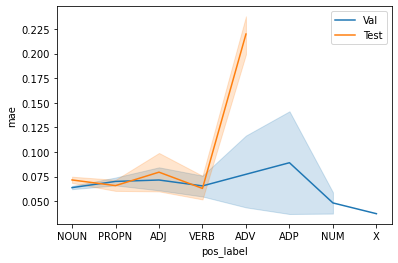

Window size of: 1


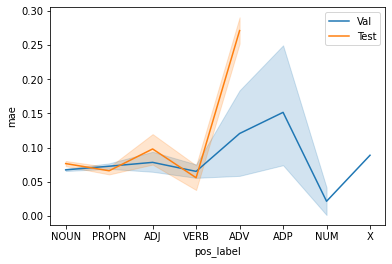

Window size of: 2


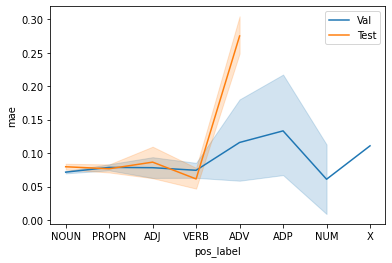

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'val')], 
                    ci=98, 
                    markers='o')
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'test')], 
                    ci=98, 
                    markers='o')
    plt.legend(['Val', 'Test'])
    plt.show()